In [1]:
import pandas as pd

def get_province(x):
    temp = x.split(' ')[0]
    if len(temp) != 4:
        return temp[:2]
    else:
        return temp[0] + temp[2]

def job_preprocessing(path):
    job_raw = pd.read_excel(path, skiprows=1)
    job_data = job_raw[job_raw['산업별'] == '전산업']
    job_data = job_data[['지역별', '전체종사자']]
    job_data.columns = ['지역명',  '고용자수']
    
    job_data['시도'] = job_data['지역명'].apply(get_province)
    job_data['구군'] = job_data['지역명'].apply(lambda x: x.split(' ')[1])
    
    return job_data

def house_number_preprocessing(path):
    house_raw = pd.read_excel(path)
    house_raw.columns = ['시도', '구군', '세대수']

    big_col = []
    for num, temp in enumerate(house_raw['시도']):
        if pd.isna(temp) :
            big_col.append(big_col[num-1])
        else:
            big_col.append(temp)
    house_raw['시도'] = big_col
    
    house_raw['시도'] = house_raw['시도'].apply(get_province)
    house_data = house_raw[house_raw['구군'] != '소계']
    
    return house_data

In [2]:
job_path = f'data/과제1_지역고용통계_20190706075534.xlsx'
job_df = job_preprocessing(job_path)

In [3]:
house_path = f'data/과제1_행정구역_시군구_별_주민등록세대수_20190706074416.xlsx'
house_df = house_number_preprocessing(house_path)

In [4]:
job_sido = job_df.groupby('시도').sum()
job_sido = job_sido.sort_values(by='고용자수', ascending=False)

# Q) 과제1_평균매매가격_아파트.xlsx 파일을 업로드 하고, house_price_preprocessing을 사용해서 데이터를 전처리 하라.

In [5]:
def house_price_preprocessing(path):
    row_price = pd.read_excel(path, skiprows=10)
    
    big_col = []
    for num, temp in enumerate(row_price['지 역']):
        if pd.isna(temp) :
            big_col.append(big_col[num-1])
        else:
            big_col.append(temp)


    small_col = []
    for num in range(len(row_price)):
        temp_list = list(row_price[['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3']].iloc[num])
        for temp in temp_list[3::-1]:
            if not pd.isna(temp):
                small_col.append(temp)
                break

    row_price.index = [big_col, small_col]
    
    transposed_price = row_price.drop(['지 역', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3'], axis=1).T
    
    time_index = []
    for time in transposed_price.index:
        temp = time.split(' ')
        time_index.append(temp[0][:-1]+'.'+temp[1][:-1])

    transposed_price.index = pd.to_datetime(time_index)
    
    return transposed_price

price_path = f'data/과제2_평균매매가격_아파트.xlsx'
price_df = house_price_preprocessing(price_path)

# Q) 데이터 분석 및 이미지 출력을 위한 설정을 진행하세요.

In [6]:
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
from matplotlib import style
style.use('ggplot')
%matplotlib inline
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)


# Q) 시도 단위의 고용자수를 막대 그래프로 보기 

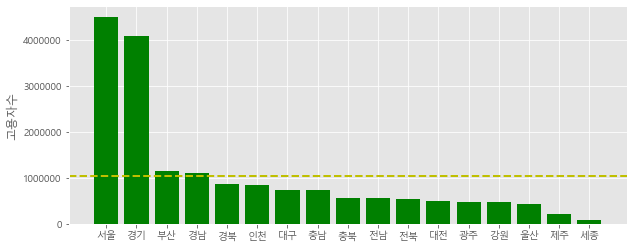

In [7]:
import numpy as np
plt.figure(figsize=(10,4))
worker_exp=np.array(list(job_sido['고용자수']))
worker=list(job_sido['고용자수'])
province=list(job_sido.index)
plt.bar(province, worker,color='g')
plt.ylabel('고용자수')
plt.axhline(y=worker_exp.mean(),linewidth=2,color='y',linestyle='--')
plt.show()

# Q) 시도 단위 세대구 대비 고용비율 막대 그래프로 보기

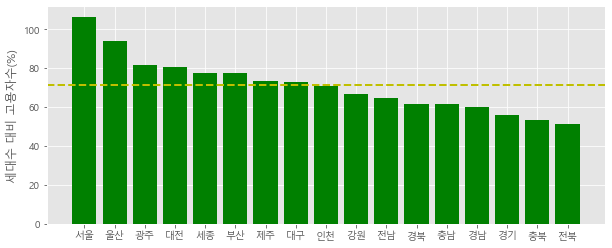

In [8]:
job_sido2 = job_df.groupby('시도').sum()
house_sido = house_df.groupby('시도').sum()

worker_per_house=[]
for i in range(len(house_sido)):
    wph=list(job_sido2['고용자수'])[i]/list(house_sido['세대수'])[i]*100
    worker_per_house.append(wph)
    
house_sido['고용자수/세대수']=worker_per_house
house_sido = house_sido.sort_values(by='고용자수/세대수', ascending=False)

plt.figure(figsize=(10,4))
plt.bar(house_sido.index,house_sido['고용자수/세대수'],color='g')
plt.ylabel('세대수 대비 고용자수(%)')
plt.axhline(y=np.array(worker_per_house).mean(),linewidth=2,color='y',linestyle='--')
plt.show()

# 고용자수, 세대수, 평균 아파트 매매가격 scatter 그래프로 나타내기
* 아래 예제는 scatter 예제 입니다. 아래 코드를 잘 분석해서 아래 문제를 해결해보세요.

강원
경기
경남
경북
광주
대구
대전
부산
서울
세종
울산
인천
전남
전북
제주
충남
충북


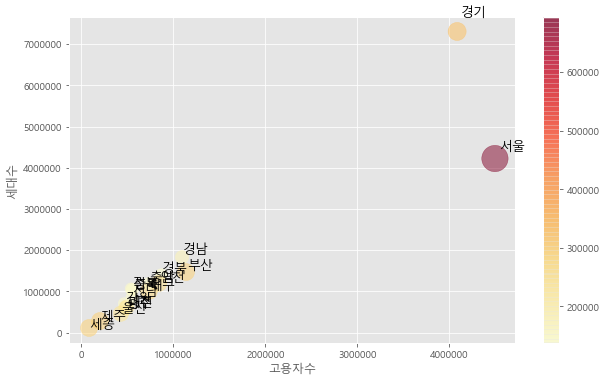

In [9]:
sido_list = []
job_sido = job_df.groupby('시도').sum()
for i in job_sido.index:
    sido_list.append(price_df.loc['2018-6-1'][i][i])
      
job_sido['평균매매가격'] = sido_list
house_sido = house_df.groupby('시도').sum()

plt.figure(figsize=(10, 6))
plt.scatter(job_sido['고용자수'], house_sido['세대수'], c=job_sido['평균매매가격'], s=job_sido['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('고용자수')
plt.ylabel('세대수')
for name in job_sido.index:
    print(name)
    plt.text(job_sido['고용자수'][name]*1.01, house_sido['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()

# Q) 세대수 대비 고용비율, 세대수, 평균 아파트 매매가격 scatter 그래프로 나타내기

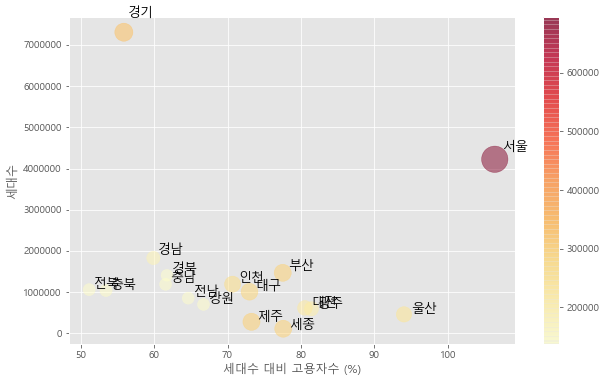

In [10]:
sido_list = []
job_sido = job_df.groupby('시도').sum()
for i in job_sido.index:
    sido_list.append(price_df.loc['2018-6-1'][i][i])
      
job_sido['평균매매가격'] = sido_list
house_sido = house_df.groupby('시도').sum()

worker_per_house=[]
for i in range(len(house_sido)):
    wph=list(job_sido2['고용자수'])[i]/list(house_sido['세대수'])[i]*100
    worker_per_house.append(wph)
    
house_sido['고용자수/세대수']=worker_per_house

plt.figure(figsize=(10, 6))
plt.scatter(house_sido['고용자수/세대수'], house_sido['세대수'], c=job_sido['평균매매가격'], s=job_sido['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('세대수 대비 고용자수 (%)')
plt.ylabel('세대수')
for name in job_sido.index:
    plt.text(house_sido['고용자수/세대수'][name]*1.01, house_sido['세대수'][name]*1.05, name, fontsize=13)

plt.colorbar()
plt.show()

# Q) 부산시의 구군별 고용자수

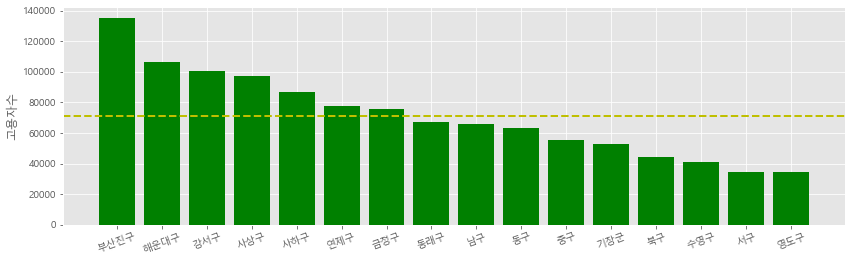

In [11]:
job_busan=job_df[job_df['시도']=='부산']
job_busan_worker=job_busan.groupby('구군').sum()
job_busan_worker=job_busan_worker.sort_values(by='고용자수',ascending=False)

plt.figure(figsize=(14,4))
worker_exp_busan=np.array(list(job_busan_worker['고용자수']))
worker_busan=list(job_busan_worker['고용자수'])
province_busan=list(job_busan_worker.index)
plt.bar(province_busan, worker_busan,color='g')
plt.xticks(rotation=20)
plt.ylabel('고용자수')
plt.axhline(y=worker_exp_busan.mean(),linewidth=2,color='y',linestyle='--')
plt.show()

# Q) 부산시의 구군별 고용비율(세대수 대비 고용자수)

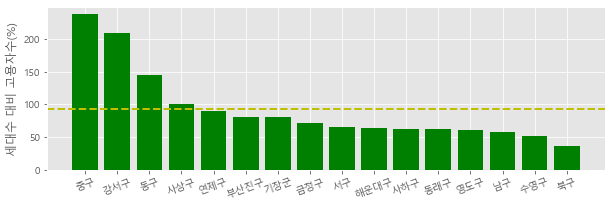

In [12]:
job_busan=job_df[job_df['시도']=='부산']
job_busan_worker=job_busan.groupby('구군').sum()
house_busan=house_df[house_df['시도']=='부산']
house_busan_worker=house_busan.groupby('구군').sum()

worker_per_house_busan=[]
for i in range(len(house_busan_worker)):
    wph=list(job_busan_worker['고용자수'])[i]/list(house_busan_worker['세대수'])[i]*100
    worker_per_house_busan.append(wph)
    
house_busan_worker['고용자수/세대수']=worker_per_house_busan
house_busan_worker = house_busan_worker.sort_values(by='고용자수/세대수', ascending=False)

plt.figure(figsize=(10,3))
plt.bar(house_busan_worker.index,house_busan_worker['고용자수/세대수'],color='g')
plt.ylabel('세대수 대비 고용자수(%)')
plt.xticks(rotation=20)
plt.axhline(y=np.array(worker_per_house_busan).mean(),linewidth=2,color='y',linestyle='--')
plt.show()

# Q) 부산시의 고용자수, 세대수, 평균 아파트 매매가로 scatter 그래프 그리기

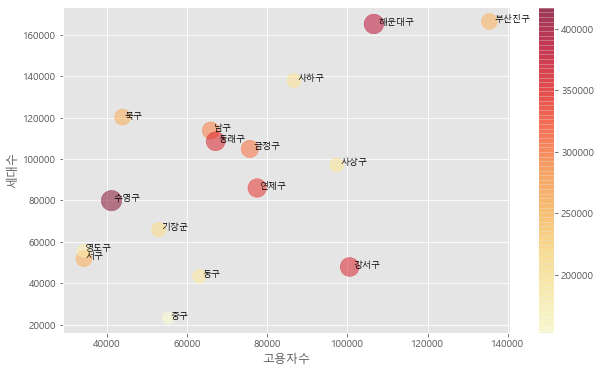

In [13]:
busan_list = []
job_busan=job_df[job_df['시도']=='부산']
job_busan_worker=job_busan.groupby('구군').sum()


for i in job_busan_worker.index:
    busan_list.append(price_df.loc['2018-6-1']['부산'][i])

job_busan_worker['평균매매가격'] = busan_list
house_busan=house_df[house_df['시도']=='부산']
house_busan_worker=house_busan.groupby('구군').sum()

plt.figure(figsize=(10, 6))
plt.scatter(job_busan_worker['고용자수'], house_busan_worker['세대수'], c=job_busan_worker['평균매매가격'], s=job_busan_worker['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
plt.xlabel('고용자수')
plt.ylabel('세대수')
for name in job_busan_worker.index:
    plt.text(job_busan_worker['고용자수'][name]*1.01, house_busan_worker['세대수'][name]*1.0, name, fontsize=9)

plt.colorbar()
plt.show()

# Q) 부산시의 고용비율, 세대수, 평균 아파트 매매가로 scatter 그래프 그리기

Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구', '사상구', '사하구',
       '서구', '수영구', '연제구', '영도구', '중구', '해운대구'],
      dtype='object', name='구군')
Index(['강서구', '금정구', '기장군', '남구', '동구', '동래구', '부산진구', '북구

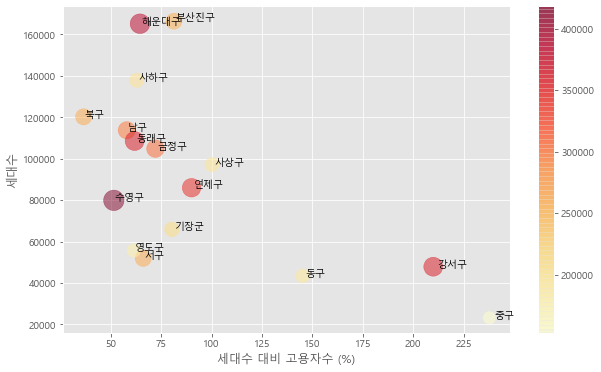

In [15]:
busan_list = []
job_busan=job_df[job_df['시도']=='부산']
job_busan_worker=job_busan.groupby('구군').sum()

for i in job_busan_worker.index:
    busan_list.append(price_df.loc['2018-6-1']['부산'][i])
      
job_busan_worker['평균매매가격'] = busan_list
house_busan=house_df[house_df['시도']=='부산']
house_busan_worker=house_busan.groupby('구군').sum()

worker_per_house_busan=[]
for i in range(len(house_busan_worker)):
    wph=list(job_busan_worker['고용자수'])[i]/list(house_busan_worker['세대수'])[i]*100
    worker_per_house_busan.append(wph)
    
house_busan_worker['고용자수/세대수']=worker_per_house_busan

plt.figure(figsize=(10, 6))
plt.scatter(house_busan_worker['고용자수/세대수'], house_busan_worker['세대수'], c=job_busan_worker['평균매매가격'], s=job_busan_worker['평균매매가격']*0.001, cmap="YlOrRd", alpha=0.5 )
#scatter(x,y,s,c,cmap,alpha) x,y:data position, s:shape size, c;color by density
plt.xlabel('세대수 대비 고용자수 (%)')
plt.ylabel('세대수')
for name in job_busan_worker.index:
    print(job_busan_worker.index)
    plt.text(house_busan_worker['고용자수/세대수'][name]*1.01, house_busan_worker['세대수'][name]*1.0, name, fontsize=10)
#text(x,y,s) x,y: position
plt.colorbar()
plt.show()